# Valorization Entreprise

Ce notebook est la deuxième tentative pour prédir `EV/EBITDA` d'une entreprise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score
import seaborn as sns
from tensorflow import keras 
from keras import layers, regularizers, optimizers
import plotly.express as px
import pickle 


### Data d'input EV/EBITDA,  P/E

In [3]:
#Importation de la data
data  = pd.read_excel ( 'Data Finpack V2/data_P_Book_Value_sans_na_sans_out_coder_normalizer_classer.xlsx', index_col = 0 )
data

,Efcode,Country_Original,Company Name,Sector_Original,Description,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,Classe,P/Book Value - Last
23,30145KN,NGA,ABC Transport PLC,Travel & Tourism,S&P Business SummaryABC Transport Plc provides...,0.865672,0.839286,-0.120907,0.029715,4,0.58
30,30268KN,NGA,Africa Prudential Plc,Investment Services,S&P Business SummaryAfrica Prudential Plc prov...,0.164179,0.839286,-0.165255,-0.701637,4,1.31
36,30033KN,NGA,Ardova Plc,Integrated Oil & Gas,"S&P Business SummaryArdova Plc, an integrated ...",0.134328,0.839286,-0.085894,-0.620376,4,2.41
39,30156KN,NGA,BOC Gases Plc,Medical Equipment,S&P Business SummaryIndustrial and Medical Gas...,0.238806,0.839286,-0.089054,0.933293,4,1.00
41,30291KN,NGA,BUA Cement Plc,Building Materials & Fixtures,S&P Business SummaryBUA Cement Plc engages in ...,-0.611940,0.839286,8.381335,2.006671,13,8.06
...,...,...,...,...,...,...,...,...,...,...,...
83778,30160AN,NZL,Vital Limited,Mobile Telecommunications,S&P Business SummaryVital Limited provides mob...,0.268657,0.928571,0.007774,1.546998,4,0.58
83779,40089AN,NZL,Volpara Health Technologies Ltd.,Biotechnology,S&P Business SummaryVolpara Health Technologie...,-0.671642,0.928571,-0.286539,-2.024257,8,3.24
83783,30035AN,NZL,Warehouse Group Ltd.,Broadline Retailers,S&P Business SummaryThe Warehouse Group Limite...,-0.626866,0.928571,4.574564,-0.095816,5,1.52
83786,30217AN,NZL,Xero Limited,Software,"S&P Business SummaryXero Limited, together wit...",0.686567,0.928571,4.182889,0.560340,5,12.84


In [5]:
px.scatter ( y = data ['P/Book Value - Last'].sort_values (ascending = True) )

#### Classe 4

In [4]:
#Selectionner la classe 4
data_classe_4 = data [data.Classe == 4]
#data_classe_4 = data 

#Selectionner les entreprises ou EV/EBITDA < 50 et > 3
data_classe_4 =  data_classe_4[ data_classe_4['EV/EBITDA - Last'] <= 50 ]
data_classe_4 =  data_classe_4[ data_classe_4['EV/EBITDA - Last'] >= 3 ]
data_classe_4

,Efcode,Country_Original,Company Name,Sector_Original,Description,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,...,Net Debt / EBITDA (x) - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,Classe,EV/EBITDA - Last
30,30268KN,NGA,Africa Prudential Plc,Investment Services,S&P Business SummaryAfrica Prudential Plc prov...,0.653543,0.568966,0.290404,0.000011,0.332641,...,0.274942,0.030318,0.000069,0.031351,0.083616,0.087517,0.110436,0.088179,4,34.04
47,30027KN,NGA,Cadbury Nigeria PLC,Food Products,S&P Business SummaryCadbury Nigeria Plc manufa...,0.653543,0.379310,0.289946,0.000205,0.310458,...,0.274943,0.030352,0.000215,0.031381,0.087068,0.091238,0.098928,0.091828,4,11.55
50,30275KN,NGA,Caverton Offshore Support Group Plc,Oil Equipment & Services,S&P Business SummaryCaverton Offshore Support ...,0.653543,0.689655,0.294606,0.000142,0.284556,...,0.274959,0.030529,0.000307,0.031422,0.109512,0.102625,0.074004,0.101947,4,3.06
53,30250KN,NGA,Chams Plc,Software,"S&P Business SummaryChams Plc, together with i...",0.653543,0.870690,0.289704,0.000019,0.293637,...,0.274799,0.030329,0.000059,0.031352,0.093674,0.098236,0.090459,0.094804,4,20.36
55,30007KN,NGA,Chemical & Allied Products Plc,Building Materials & Fixtures,S&P Business SummaryChemical and Allied Produc...,0.653543,0.120690,0.289327,0.000075,0.358275,...,0.274948,0.030388,0.000048,0.031330,0.100746,0.105948,0.135806,0.131422,4,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83674,40025AN,NZL,Metro Performance Glass Ltd.,Building Materials & Fixtures,S&P Business SummaryMetro Performance Glass Li...,0.692913,0.120690,0.292316,0.000276,0.303723,...,0.274938,0.030474,0.000312,0.031485,0.093637,0.092890,0.094304,0.092938,4,3.54
83676,30029AN,NZL,Millennium & Copthorne Hotels New Zealand Limited,Hotels,S&P Business SummaryMillennium & Copthorne Hot...,0.692913,0.508621,0.290404,0.000157,0.314781,...,0.274954,0.030622,0.000745,0.032691,0.116956,0.118746,0.098092,0.099008,4,5.52
83681,40127AN,NZL,NZ Automotive Investments Ltd.,Specialty Retailers,S&P Business SummaryNZ Automotive Investments ...,0.692913,0.913793,0.292101,0.000079,0.328452,...,0.274957,0.030359,0.000030,0.031315,0.092065,0.093846,0.102660,0.104086,4,3.83
83684,40096AN,NZL,NZME Ltd.,Broadcasting & Entertainment,"S&P Business SummaryNZME Limited, together wit...",0.692913,0.103448,0.291024,0.000378,0.329659,...,0.274939,0.030702,0.000322,0.031583,0.101025,0.100445,0.109876,0.103767,4,3.31


In [501]:
#Nombre d'entreprise dans chaque tranche
i = 27
j = 50
data_classe_4[( data_classe_4['EV/EBITDA - Last'] <= j) & (data_classe_4['EV/EBITDA - Last'] >= i )].shape

(1272, 24)

In [502]:
#Ajoutons une colonne de valeur 0 à la data
data_classe_4 ['classe_4_sous_classe'] = 0
data_classe_4

,Efcode,Country_Original,Company Name,Sector_Original,Description,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,...,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,Classe,EV/EBITDA - Last,classe_4_sous_classe
30,30268KN,NGA,Africa Prudential Plc,Investment Services,S&P Business SummaryAfrica Prudential Plc prov...,0.653543,0.568966,0.290404,0.000011,0.332641,...,0.030318,0.000069,0.031351,0.083616,0.087517,0.110436,0.088179,4,34.04,0
47,30027KN,NGA,Cadbury Nigeria PLC,Food Products,S&P Business SummaryCadbury Nigeria Plc manufa...,0.653543,0.379310,0.289946,0.000205,0.310458,...,0.030352,0.000215,0.031381,0.087068,0.091238,0.098928,0.091828,4,11.55,0
50,30275KN,NGA,Caverton Offshore Support Group Plc,Oil Equipment & Services,S&P Business SummaryCaverton Offshore Support ...,0.653543,0.689655,0.294606,0.000142,0.284556,...,0.030529,0.000307,0.031422,0.109512,0.102625,0.074004,0.101947,4,3.06,0
52,30216KN,NGA,Champion Breweries PLC,Brewers,S&P Business SummaryChampion Breweries Plc bre...,0.653543,0.094828,0.289839,0.000047,0.330865,...,0.030396,0.000056,0.031364,0.112806,0.108110,0.109629,0.108800,12,12.16,0
53,30250KN,NGA,Chams Plc,Software,"S&P Business SummaryChams Plc, together with i...",0.653543,0.870690,0.289704,0.000019,0.293637,...,0.030329,0.000059,0.031352,0.093674,0.098236,0.090459,0.094804,4,20.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,30029AN,NZL,Millennium & Copthorne Hotels New Zealand Limited,Hotels,S&P Business SummaryMillennium & Copthorne Hot...,0.692913,0.508621,0.290404,0.000157,0.314781,...,0.030622,0.000745,0.032691,0.116956,0.118746,0.098092,0.099008,4,5.52,0
83681,40127AN,NZL,NZ Automotive Investments Ltd.,Specialty Retailers,S&P Business SummaryNZ Automotive Investments ...,0.692913,0.913793,0.292101,0.000079,0.328452,...,0.030359,0.000030,0.031315,0.092065,0.093846,0.102660,0.104086,4,3.83,0
83682,30187AN,NZL,NZ Windfarms Ltd.,Alternative Electricity,S&P Business SummaryNZ Windfarms Limited gener...,0.692913,0.017241,0.291104,0.000017,0.336092,...,0.030366,0.000057,0.031369,0.153878,0.155850,0.107293,0.104141,12,5.28,0
83684,40096AN,NZL,NZME Ltd.,Broadcasting & Entertainment,"S&P Business SummaryNZME Limited, together wit...",0.692913,0.103448,0.291024,0.000378,0.329659,...,0.030702,0.000322,0.031583,0.101025,0.100445,0.109876,0.103767,4,3.31,0


In [503]:
#Donnons les labels au sous classe
data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 6) &  (data_classe_4['EV/EBITDA - Last'] >= 3 ), 'classe_4_sous_classe'] = 0
data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 9) & (data_classe_4['EV/EBITDA - Last'] > 6 ), 'classe_4_sous_classe'] = 1
data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 12) & (data_classe_4['EV/EBITDA - Last'] > 9 ), 'classe_4_sous_classe'] = 2
data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 15) & (data_classe_4['EV/EBITDA - Last'] > 12 ), 'classe_4_sous_classe'] = 3
data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 18) & (data_classe_4['EV/EBITDA - Last'] > 15 ), 'classe_4_sous_classe'] = 4
data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 21) & (data_classe_4['EV/EBITDA - Last'] > 18 ), 'classe_4_sous_classe'] = 5
data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 27) & (data_classe_4['EV/EBITDA - Last'] > 21 ), 'classe_4_sous_classe'] = 6
data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 50) & (data_classe_4['EV/EBITDA - Last'] > 27 ), 'classe_4_sous_classe'] = 7
#data_classe_4.loc[( data_classe_4['EV/EBITDA - Last'] <= 50) & (data_classe_4['EV/EBITDA - Last'] > 33 ), 'classe_4_sous_classe'] = 9

In [504]:
#Ajoutons une colonne montrons l'intervalle EV/EBITDA correspondant
data_classe_4_ = data_classe_4.copy()
data_classe_4_['Intervalle EV/EBITDA - Last'] = 'N'
data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 6) &  (data_classe_4['EV/EBITDA - Last'] >= 3 ), 'Intervalle EV/EBITDA - Last'] = '3-6'
data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 9) &  (data_classe_4['EV/EBITDA - Last'] > 6 ), 'Intervalle EV/EBITDA - Last'] = '6-9'
data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 12) & (data_classe_4['EV/EBITDA - Last'] > 9 ), 'Intervalle EV/EBITDA - Last'] = '9-12'
data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 15) & (data_classe_4['EV/EBITDA - Last'] > 12 ), 'Intervalle EV/EBITDA - Last'] = '12-15'
data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 18) & (data_classe_4['EV/EBITDA - Last'] > 15 ), 'Intervalle EV/EBITDA - Last'] = '15-18'
data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 21) & (data_classe_4['EV/EBITDA - Last'] > 18 ), 'Intervalle EV/EBITDA - Last'] = '18-21'
data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 27) & (data_classe_4['EV/EBITDA - Last'] > 21 ), 'Intervalle EV/EBITDA - Last'] = '21-27'
data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 50) & (data_classe_4['EV/EBITDA - Last'] > 27 ), 'Intervalle EV/EBITDA - Last'] = '27-50'
#data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 33) & (data_classe_4['EV/EBITDA - Last'] > 27 ), 'Intervalle EV/EBITDA - Last'] = '27-33'
#data_classe_4_.loc[( data_classe_4['EV/EBITDA - Last'] <= 50) & (data_classe_4['EV/EBITDA - Last'] > 33 ), 'Intervalle EV/EBITDA - Last'] = '33-50'

data_classe_4_

,Efcode,Country_Original,Company Name,Sector_Original,Description,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,...,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,Classe,EV/EBITDA - Last,classe_4_sous_classe,Intervalle EV/EBITDA - Last
30,30268KN,NGA,Africa Prudential Plc,Investment Services,S&P Business SummaryAfrica Prudential Plc prov...,0.653543,0.568966,0.290404,0.000011,0.332641,...,0.000069,0.031351,0.083616,0.087517,0.110436,0.088179,4,34.04,7,27-50
47,30027KN,NGA,Cadbury Nigeria PLC,Food Products,S&P Business SummaryCadbury Nigeria Plc manufa...,0.653543,0.379310,0.289946,0.000205,0.310458,...,0.000215,0.031381,0.087068,0.091238,0.098928,0.091828,4,11.55,2,9-12
50,30275KN,NGA,Caverton Offshore Support Group Plc,Oil Equipment & Services,S&P Business SummaryCaverton Offshore Support ...,0.653543,0.689655,0.294606,0.000142,0.284556,...,0.000307,0.031422,0.109512,0.102625,0.074004,0.101947,4,3.06,0,3-6
52,30216KN,NGA,Champion Breweries PLC,Brewers,S&P Business SummaryChampion Breweries Plc bre...,0.653543,0.094828,0.289839,0.000047,0.330865,...,0.000056,0.031364,0.112806,0.108110,0.109629,0.108800,12,12.16,3,12-15
53,30250KN,NGA,Chams Plc,Software,"S&P Business SummaryChams Plc, together with i...",0.653543,0.870690,0.289704,0.000019,0.293637,...,0.000059,0.031352,0.093674,0.098236,0.090459,0.094804,4,20.36,5,18-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,30029AN,NZL,Millennium & Copthorne Hotels New Zealand Limited,Hotels,S&P Business SummaryMillennium & Copthorne Hot...,0.692913,0.508621,0.290404,0.000157,0.314781,...,0.000745,0.032691,0.116956,0.118746,0.098092,0.099008,4,5.52,0,3-6
83681,40127AN,NZL,NZ Automotive Investments Ltd.,Specialty Retailers,S&P Business SummaryNZ Automotive Investments ...,0.692913,0.913793,0.292101,0.000079,0.328452,...,0.000030,0.031315,0.092065,0.093846,0.102660,0.104086,4,3.83,0,3-6
83682,30187AN,NZL,NZ Windfarms Ltd.,Alternative Electricity,S&P Business SummaryNZ Windfarms Limited gener...,0.692913,0.017241,0.291104,0.000017,0.336092,...,0.000057,0.031369,0.153878,0.155850,0.107293,0.104141,12,5.28,0,3-6
83684,40096AN,NZL,NZME Ltd.,Broadcasting & Entertainment,"S&P Business SummaryNZME Limited, together wit...",0.692913,0.103448,0.291024,0.000378,0.329659,...,0.000322,0.031583,0.101025,0.100445,0.109876,0.103767,4,3.31,0,3-6


In [505]:
# Verfication
data_classe_4_['Intervalle EV/EBITDA - Last'].value_counts()

3-6      2874
6-9      2431
9-12     1662
27-50    1271
12-15    1268
15-18     873
21-27     871
18-21     671
Name: Intervalle EV/EBITDA - Last, dtype: int64

In [506]:
data_classe_4_['classe_4_sous_classe'].value_counts()

0    2874
1    2431
2    1662
7    1271
3    1268
4     873
6     871
5     671
Name: classe_4_sous_classe, dtype: int64

In [507]:
#data input 
data_input = data_classe_4_.drop ( [ 'Efcode', 'Country_Original', 'Company Name', 'Sector_Original', 'Description', 'Classe', 'EV/EBITDA - Last', 'Intervalle EV/EBITDA - Last' ], axis = 1  )
data_input

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Fin. Debt / Equity (%) - Last,Fin. Debt / Assets (%) - Last,Net Debt / EBITDA (x) - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,classe_4_sous_classe
30,0.653543,0.568966,0.290404,0.000011,0.332641,0.008816,0.052871,0.091306,0.000071,0.274942,0.030318,0.000069,0.031351,0.083616,0.087517,0.110436,0.088179,7
47,0.653543,0.379310,0.289946,0.000205,0.310458,0.093082,0.069000,0.251126,0.040362,0.274943,0.030352,0.000215,0.031381,0.087068,0.091238,0.098928,0.091828,2
50,0.653543,0.689655,0.294606,0.000142,0.284556,0.044674,0.057497,0.255623,0.040139,0.274959,0.030529,0.000307,0.031422,0.109512,0.102625,0.074004,0.101947,0
52,0.653543,0.094828,0.289839,0.000047,0.330865,0.078509,0.271459,0.091306,0.000071,0.274947,0.030396,0.000056,0.031364,0.112806,0.108110,0.109629,0.108800,3
53,0.653543,0.870690,0.289704,0.000019,0.293637,0.028320,0.052279,0.114996,0.010540,0.274799,0.030329,0.000059,0.031352,0.093674,0.098236,0.090459,0.094804,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83676,0.692913,0.508621,0.290404,0.000157,0.314781,0.020480,0.067760,0.140984,0.030590,0.274954,0.030622,0.000745,0.032691,0.116956,0.118746,0.098092,0.099008,0
83681,0.692913,0.913793,0.292101,0.000079,0.328452,0.171923,0.247832,0.158126,0.033136,0.274957,0.030359,0.000030,0.031315,0.092065,0.093846,0.102660,0.104086,0
83682,0.692913,0.017241,0.291104,0.000017,0.336092,0.019826,0.056094,0.091306,0.000071,0.274948,0.030366,0.000057,0.031369,0.153878,0.155850,0.107293,0.104141,0
83684,0.692913,0.103448,0.291024,0.000378,0.329659,0.116823,0.057697,0.102505,0.007852,0.274939,0.030702,0.000322,0.031583,0.101025,0.100445,0.109876,0.103767,0


In [508]:
data_input['classe_4_sous_classe'].value_counts()

0    2874
1    2431
2    1662
7    1271
3    1268
4     873
6     871
5     671
Name: classe_4_sous_classe, dtype: int64

#####  X et y train test split

In [509]:
data_shuffled = data_input.sample ( frac = 1, random_state = 40 )
data_shuffled

,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,Sales To Assets (%) - Last,Sales To Receiv. - Last,Fin. Debt / Equity (%) - Last,Fin. Debt / Assets (%) - Last,Net Debt / EBITDA (x) - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,classe_4_sous_classe
73337,0.448819,0.474138,0.291078,0.001267,0.317495,0.080492,0.051402,0.101993,0.006063,0.274946,0.030899,0.001619,0.032853,0.091134,0.096602,0.102071,0.098790,1
50603,0.141732,0.474138,0.290970,0.000157,0.318165,0.013274,0.050076,0.198784,0.026982,0.274958,0.030557,0.001165,0.032490,0.112164,0.105475,0.101064,0.094231,5
56113,0.141732,0.112069,0.294659,0.003464,0.310324,0.008756,0.194409,0.107551,0.012814,0.274944,0.032056,0.041544,0.044803,0.092623,0.098338,0.103960,0.092310,7
75719,0.448819,0.896552,0.290862,0.000850,0.330061,0.057053,0.052880,0.107569,0.012197,0.274947,0.031788,0.001629,0.033071,0.108711,0.105837,0.108660,0.104477,0
17382,0.937008,0.224138,0.295010,0.048330,0.313340,0.021869,0.063964,0.251108,0.042939,0.274972,0.118958,0.223175,0.150644,0.114099,0.111563,0.104786,0.095932,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75570,0.448819,0.758621,0.288627,0.000120,0.397916,0.093696,0.056342,0.091306,0.000071,0.274939,0.030420,0.000092,0.031439,0.106394,0.105744,0.104274,0.138156,2
47542,0.141732,0.698276,0.291805,0.002287,0.316791,0.057777,0.061569,0.122798,0.023324,0.274955,0.031876,0.003985,0.035909,0.095387,0.099637,0.101302,0.098799,3
61236,0.204724,0.629310,0.295090,0.202098,0.313574,0.038585,0.056056,0.121214,0.018705,0.274979,0.481791,0.528691,0.354299,0.120594,0.104547,0.103818,0.096788,1
75107,0.448819,0.715517,0.292990,0.002250,0.322856,0.050541,0.052518,0.101874,0.008458,0.274946,0.032659,0.004482,0.035031,0.101239,0.101280,0.106961,0.097561,1


In [510]:
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

X = data_shuffled.drop ( ['classe_4_sous_classe'], axis = 1 )
y = data_shuffled ['classe_4_sous_classe']
#YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY
y

73337    1
50603    5
56113    7
75719    0
17382    3
        ..
75570    2
47542    3
61236    1
75107    1
75673    0
Name: classe_4_sous_classe, Length: 11921, dtype: int64

In [514]:
#X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split ( X, y, stratify = y, train_size = 0.985 )
#X_train,  X_validation, y_train, y_validation = train_test_split ( X_train, y_train, stratify = y_train,  train_size = 0.96 )
print ( 'X_train size :', X_train.shape )
print ( 'y_train size :', y_train.shape )
#print ( 'X_validation size :', X_validation.shape )
#print ( 'y_validation size :', y_validation.shape )
print ( 'X_test size :', X_test.shape )
print ( 'y_test size :', y_test.shape )

X_train size : (11742, 17)
y_train size : (11742,)
X_test size : (179, 17)
y_test size : (179,)


In [516]:
y_test.value_counts()

0    43
1    37
2    25
7    19
3    19
6    13
4    13
5    10
Name: classe_4_sous_classe, dtype: int64

### Collecte de la data : |EV/EBITDA0| EV/EBITDA1| .... | EV/EBITDA10| Sector_Originale| Classe|

In [10]:
data [data['P/Book Value - Last'] <= 3]

,Efcode,Country_Original,Company Name,Sector_Original,Description,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,Classe,P/Book Value - Last
23,30145KN,NGA,ABC Transport PLC,Travel & Tourism,S&P Business SummaryABC Transport Plc provides...,0.865672,0.839286,-0.120907,0.029715,4,0.58
30,30268KN,NGA,Africa Prudential Plc,Investment Services,S&P Business SummaryAfrica Prudential Plc prov...,0.164179,0.839286,-0.165255,-0.701637,4,1.31
36,30033KN,NGA,Ardova Plc,Integrated Oil & Gas,"S&P Business SummaryArdova Plc, an integrated ...",0.134328,0.839286,-0.085894,-0.620376,4,2.41
39,30156KN,NGA,BOC Gases Plc,Medical Equipment,S&P Business SummaryIndustrial and Medical Gas...,0.238806,0.839286,-0.089054,0.933293,4,1.00
43,30046KN,NGA,Berger Paints Nigeria PLC,Specialty Chemicals,S&P Business SummaryBerger Paints Nigeria Plc ...,0.731343,0.839286,-0.123795,0.066707,4,0.59
...,...,...,...,...,...,...,...,...,...,...,...
83768,30083AN,NZL,Tourism Holdings Limited,Travel & Tourism,"S&P Business SummaryTourism Holdings Limited, ...",0.865672,0.928571,0.620521,0.235294,4,2.57
83776,40026AN,NZL,Vista Group International Ltd.,Software,S&P Business SummaryVista Group International ...,0.686567,0.928571,-0.049956,-0.329897,2,2.19
83777,30054AN,NZL,Vital Healthcare Property Trust,Speciality REITs,S&P Business SummaryVital Healthcare Property ...,0.701493,0.928571,1.154673,2.952699,7,0.71
83778,30160AN,NZL,Vital Limited,Mobile Telecommunications,S&P Business SummaryVital Limited provides mob...,0.268657,0.928571,0.007774,1.546998,4,0.58


In [19]:
#  3  <= P/E <=  50
data.loc [ (data['P/Book Value - Last'] <= 11) & (data['P/Book Value - Last'] >= 10) ]

,Efcode,Country_Original,Company Name,Sector_Original,Description,Sector,Country,EBITDA - Last,EBITDA Marg. (%) - Last,Classe,P/Book Value - Last
992,30435FP,PAK,Mitchell's Fruit Farms Ltd.,Food Products,S&P Business SummaryMitchell’s Fruit Farms Lim...,-0.164179,0.964286,-0.227128,-1.929654,8,10.02
1158,U1000PA,PAK,Systems Ltd.,Software,S&P Business SummarySystems Limited engages in...,0.686567,0.964286,0.701810,0.877502,4,10.73
2539,40198EO,POL,IFIRMA S.A.,Computer Services,S&P Business SummaryIFirma SA engages in the p...,-0.492537,1.071429,-0.110772,0.686477,4,10.91
2756,40457EO,POL,Neptis SA,Aerospace,S&P Business SummaryNeptis Spólka Akcyjna manu...,-0.820896,1.071429,-0.127976,0.084294,4,10.38
2911,40809EO,POL,Read-Gene SA,Biotechnology,S&P Business SummaryRead-Gene S.A. engages in ...,-0.671642,1.071429,-0.160326,-0.035779,12,10.10
...,...,...,...,...,...,...,...,...,...,...,...
75286,33059FJ,JPN,"Kobe Bussan Co., Ltd.",Food Retailers & Wholesalers,"S&P Business SummaryKobe Bussan Co., Ltd. oper...",-0.149254,0.375000,5.278968,-0.169800,13,10.37
75464,U1331JP,JPN,"United & Collective Co., Ltd.",Food Retailers & Wholesalers,"S&P Business SummaryUnited & Collective Co., L...",-0.149254,0.375000,-0.340037,-1.753790,12,10.74
75580,40845FJ,JPN,"Kamakura Shinsho, Ltd.",Publishing,"S&P Business SummaryKamakura Shinsho, Ltd. ope...",0.492537,0.375000,-0.011191,0.321407,0,10.85
75596,41356FJ,JPN,"NexTone, Inc.",Publishing,S&P Business SummaryNexTone Inc. provides musi...,0.492537,0.375000,0.007226,0.027896,0,10.38


#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
#Selectionner la classe 4
data_classe_4 = data [data.Classe == 4]
#data_classe_4 = data 

#Selectionner les entreprises ou EV/EBITDA < 50 et > 3
data_classe_4 =  data_classe_4[ data_classe_4['EV/EBITDA - Last'] <= 50 ]
data_classe_4 =  data_classe_4[ data_classe_4['EV/EBITDA - Last'] >= 3 ]
data_classe_4

,Efcode,Country_Original,Company Name,Sector_Original,Description,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,...,Net Debt / EBITDA (x) - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,Classe,EV/EBITDA - Last
30,30268KN,NGA,Africa Prudential Plc,Investment Services,S&P Business SummaryAfrica Prudential Plc prov...,0.653543,0.568966,0.290404,0.000011,0.332641,...,0.274942,0.030318,0.000069,0.031351,0.083616,0.087517,0.110436,0.088179,4,34.04
47,30027KN,NGA,Cadbury Nigeria PLC,Food Products,S&P Business SummaryCadbury Nigeria Plc manufa...,0.653543,0.379310,0.289946,0.000205,0.310458,...,0.274943,0.030352,0.000215,0.031381,0.087068,0.091238,0.098928,0.091828,4,11.55
50,30275KN,NGA,Caverton Offshore Support Group Plc,Oil Equipment & Services,S&P Business SummaryCaverton Offshore Support ...,0.653543,0.689655,0.294606,0.000142,0.284556,...,0.274959,0.030529,0.000307,0.031422,0.109512,0.102625,0.074004,0.101947,4,3.06
53,30250KN,NGA,Chams Plc,Software,"S&P Business SummaryChams Plc, together with i...",0.653543,0.870690,0.289704,0.000019,0.293637,...,0.274799,0.030329,0.000059,0.031352,0.093674,0.098236,0.090459,0.094804,4,20.36
55,30007KN,NGA,Chemical & Allied Products Plc,Building Materials & Fixtures,S&P Business SummaryChemical and Allied Produc...,0.653543,0.120690,0.289327,0.000075,0.358275,...,0.274948,0.030388,0.000048,0.031330,0.100746,0.105948,0.135806,0.131422,4,3.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83674,40025AN,NZL,Metro Performance Glass Ltd.,Building Materials & Fixtures,S&P Business SummaryMetro Performance Glass Li...,0.692913,0.120690,0.292316,0.000276,0.303723,...,0.274938,0.030474,0.000312,0.031485,0.093637,0.092890,0.094304,0.092938,4,3.54
83676,30029AN,NZL,Millennium & Copthorne Hotels New Zealand Limited,Hotels,S&P Business SummaryMillennium & Copthorne Hot...,0.692913,0.508621,0.290404,0.000157,0.314781,...,0.274954,0.030622,0.000745,0.032691,0.116956,0.118746,0.098092,0.099008,4,5.52
83681,40127AN,NZL,NZ Automotive Investments Ltd.,Specialty Retailers,S&P Business SummaryNZ Automotive Investments ...,0.692913,0.913793,0.292101,0.000079,0.328452,...,0.274957,0.030359,0.000030,0.031315,0.092065,0.093846,0.102660,0.104086,4,3.83
83684,40096AN,NZL,NZME Ltd.,Broadcasting & Entertainment,"S&P Business SummaryNZME Limited, together wit...",0.692913,0.103448,0.291024,0.000378,0.329659,...,0.274939,0.030702,0.000322,0.031583,0.101025,0.100445,0.109876,0.103767,4,3.31


In [4]:
data_classe_4['Sector_Original'].value_counts().index[4]

'Heavy Construction'

In [462]:
data_4_secteur_1 = data_classe_4 [data_classe_4 ['Sector_Original'] == 'Heavy Construction']
data_4_secteur_1

,Efcode,Country_Original,Company Name,Sector_Original,Description,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,...,Net Debt / EBITDA (x) - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,Classe,EV/EBITDA - Last
96,30106KN,NGA,Interlinked Technologies Plc,Heavy Construction,S&P Business SummaryEunisell Interlinked Plc d...,0.653543,0.474138,0.294848,0.000007,0.307040,...,0.274976,0.030319,0.000002,0.031282,0.100839,0.105493,0.097437,0.096988,4,28.04
195,30197SN,NOR,AF Gruppen ASA,Heavy Construction,"S&P Business SummaryAF Gruppen ASA, a contract...",0.677165,0.474138,0.290916,0.005214,0.330630,...,0.274951,0.032131,0.002439,0.032512,0.089906,0.094941,0.120567,0.109182,4,8.28
375,40216SN,NOR,Multiconsult ASA,Heavy Construction,S&P Business SummaryMulticonsult ASA provides ...,0.677165,0.474138,0.292451,0.000825,0.337935,...,0.274954,0.030906,0.000508,0.031630,0.095954,0.098885,0.126046,0.105515,4,7.54
394,40331SN,NOR,Norbit ASA,Heavy Construction,S&P Business SummaryNORBIT ASA provides techno...,0.677165,0.474138,0.292155,0.000202,0.336863,...,0.274955,0.030545,0.000206,0.031492,0.103035,0.102728,0.113284,0.104404,4,11.43
2192,40595EO,POL,Aqua SA,Heavy Construction,S&P Business SummaryAqua S.A. engages in envir...,0.755906,0.474138,0.290189,0.000009,0.315920,...,0.274949,0.030320,0.000007,0.031284,0.099388,0.103953,0.109202,0.082464,4,6.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71218,30129EI,ITA,Caltagirone SpA,Heavy Construction,"S&P Business SummaryCaltagirone SpA, through i...",0.425197,0.474138,0.290835,0.002917,0.313440,...,0.274950,0.033688,0.006873,0.040689,0.100458,0.099934,0.099213,0.099873,4,4.92
71260,31190EI,ITA,DBA Group SpA,Heavy Construction,S&P Business SummaryDBA Group S.p.A. provides ...,0.425197,0.474138,0.292155,0.000153,0.300707,...,0.274964,0.030369,0.000119,0.031353,0.089924,0.092324,0.097893,0.093821,4,5.80
71298,31286EI,ITA,EdiliziAcrobatica SpA,Heavy Construction,S&P Business SummaryEdiliziAcrobatica S.p.A. e...,0.425197,0.474138,0.290243,0.000169,0.351138,...,0.274962,0.030629,0.000221,0.031410,0.105697,0.110876,0.145349,0.191337,4,6.62
71644,30213EI,ITA,Trevi Finanziaria Industriale S.p.A.,Heavy Construction,S&P Business SummaryTREVI - Finanziaria Indust...,0.425197,0.474138,0.296518,0.000934,0.279027,...,0.274942,0.030988,0.001347,0.031613,0.095089,0.096621,0.074611,0.099536,4,6.98


In [463]:
EV_EBITDA_3_6 = data_4_secteur_1.loc[( data_4_secteur_1['EV/EBITDA - Last'] <= 6) &  (data_4_secteur_1['EV/EBITDA - Last'] >= 3 )] 
EV_EBITDA_3_6.shape

(53, 24)

In [457]:
entreprises_1 =  EV_EBITDA_3_6[ 0:11 ]
entreprises_1

,Efcode,Country_Original,Company Name,Sector_Original,Description,Country,Sector,Net Debt / Equity (x) - Last,Net Sales - Last,ROA - Last,...,Net Debt / EBITDA (x) - Last,EBITDA - Last,Total Assets - Last,Sharehold. Equity - Last,EBITDA Marg. (%) - Last,EBIT Marg. (%) - Last,ROE (%) - Last,ROCE (%) - Last,Classe,EV/EBITDA - Last
44708,40137WB,CYM,Best Food Holding Company Limited,Clothing & Accessories,S&P Business SummaryBest Food Holding Company ...,0.181102,0.146552,0.291993,0.000170,0.283048,...,0.274951,0.030403,0.000547,0.031770,0.092697,0.075442,0.080137,0.085740,4,29.12
44728,40118WB,CYM,China Apex Group Ltd.,Clothing & Accessories,"S&P Business SummaryChina Apex Group Limited, ...",0.181102,0.146552,0.290512,0.000057,0.283618,...,0.274949,0.030364,0.000065,0.031362,0.100681,0.092807,0.093715,0.093139,4,37.44
54135,43219PC,CHN,Beijing Sanfo Outdoor Products Co. Ltd.,Clothing & Accessories,S&P Business SummaryBeijing Sanfo Outdoor Prod...,0.141732,0.146552,0.290350,0.000150,0.294944,...,0.274962,0.030374,0.000213,0.031609,0.091972,0.094087,0.098862,0.094103,4,33.47
54342,31747PC,CHN,"Hongda High-Tech Holding Co., Ltd.",Clothing & Accessories,S&P Business SummaryHongda High-Tech Holding C...,0.141732,0.146552,0.290189,0.000157,0.315116,...,0.275205,0.030445,0.000519,0.032258,0.099658,0.098960,0.098786,0.097406,4,35.75
54407,31199PC,CHN,"Jiangsu Huaxicun Co., Ltd",Clothing & Accessories,"S&P Business SummaryJiangsu Huaxicun Co.,Ltd. ...",0.141732,0.146552,0.290943,0.000628,0.319204,...,0.274936,0.030573,0.001531,0.033809,0.090297,0.093985,0.098719,0.097243,4,37.45
54415,40191PC,CHN,Jihua Group Corporation Limited,Clothing & Accessories,S&P Business SummaryJihua Group Corporation Li...,0.141732,0.146552,0.290350,0.004030,0.302416,...,0.274954,0.031407,0.006634,0.039810,0.089087,0.093187,0.096061,0.093057,4,32.89
54442,31191PC,CHN,"LianChuang Electronic Technology Co., Ltd.",Clothing & Accessories,S&P Business SummaryLianchuang Electronic Tech...,0.141732,0.146552,0.293690,0.002595,0.307308,...,0.274951,0.031483,0.003602,0.033586,0.091776,0.093354,0.096849,0.093639,4,28.65
54638,30984PC,CHN,"Shijiazhuang Changshan Beiming Technology Co.,...",Clothing & Accessories,S&P Business SummaryShijiazhuang ChangShan Bei...,0.141732,0.146552,0.292236,0.002803,0.307107,...,0.274954,0.030738,0.003969,0.034261,0.087245,0.090830,0.091560,0.090891,4,38.92
54641,31142PC,CHN,Sichuan Langsha Holding Ltd.,Clothing & Accessories,S&P Business SummarySichuan Langsha Holding Lt...,0.141732,0.146552,0.288896,0.000110,0.314245,...,0.274961,0.030361,0.000159,0.031544,0.093246,0.094134,0.097941,0.097088,4,36.15
67940,31131FI,IND,Visagar Polytex Limited,Clothing & Accessories,S&P Business SummaryVisagar Polytex Limited en...,0.385827,0.146552,0.291778,0.000007,0.298328,...,0.274952,0.030318,0.000006,0.031288,0.078060,0.008223,0.087857,0.088425,4,39.34


In [458]:
#Construction de la première ligne
classe_4_secteur_1_ev_ebitda_3_6_entreprise_2 = pd.DataFrame ( { 'EV/EBITDA0' : entreprises_1['EV/EBITDA - Last'].iloc[0] }, index = [0] )
for i in range (1, 11):
    classe_4_secteur_1_ev_ebitda_3_6_entreprise_2 ['EV/EBITDA' + str(i)] = entreprises_1['EV/EBITDA - Last'].iloc[i]
classe_4_secteur_1_ev_ebitda_3_6_entreprise_2 ['Sector_Original'] = entreprises_1['Sector_Original'].iloc[0]
classe_4_secteur_1_ev_ebitda_3_6_entreprise_2 ['Sector'] = entreprises_1['Sector'].iloc[0]
classe_4_secteur_1_ev_ebitda_3_6_entreprise_2 ['Classe'] = entreprises_1['Classe'].iloc[0]
classe_4_secteur_1_ev_ebitda_3_6_entreprise_2

,EV/EBITDA0,EV/EBITDA1,EV/EBITDA2,EV/EBITDA3,EV/EBITDA4,EV/EBITDA5,EV/EBITDA6,EV/EBITDA7,EV/EBITDA8,EV/EBITDA9,EV/EBITDA10,Sector_Original,Sector,Classe
0,29.12,37.44,33.47,35.75,37.45,32.89,28.65,38.92,36.15,39.34,32.28,Clothing & Accessories,0.146552,4


In [459]:
data_ev_ebitda = pd.concat ( [data_ev_ebitda, classe_4_secteur_1_ev_ebitda_3_6_entreprise_2] )
data_ev_ebitda

,EV/EBITDA0,EV/EBITDA1,EV/EBITDA2,EV/EBITDA3,EV/EBITDA4,EV/EBITDA5,EV/EBITDA6,EV/EBITDA7,EV/EBITDA8,EV/EBITDA9,EV/EBITDA10,Sector_Original,Sector,Classe
0,3.02,5.80,4.84,3.28,5.10,5.87,4.29,5.74,3.25,4.02,3.78,Real Estate Holding & Development,0.775862,4
0,3.27,5.07,4.95,4.25,4.51,4.03,4.71,4.35,3.34,5.01,4.10,Real Estate Holding & Development,0.775862,4
0,6.64,7.62,6.61,6.09,7.85,6.43,7.19,7.12,8.31,7.12,6.14,Real Estate Holding & Development,0.775862,4
0,6.20,7.26,8.25,8.17,6.36,7.88,6.37,6.42,6.77,6.08,8.81,Real Estate Holding & Development,0.775862,4
0,7.71,8.73,8.30,7.33,7.55,7.67,8.97,7.63,7.28,8.24,8.73,Real Estate Holding & Development,0.775862,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,12.07,12.31,10.45,11.35,10.74,11.73,10.35,12.46,11.45,10.87,14.13,Clothing & Accessories,0.146552,4
0,14.70,14.86,16.25,15.34,14.89,16.15,15.66,14.95,14.89,14.70,16.36,Clothing & Accessories,0.146552,4
0,19.45,17.67,20.72,20.49,17.85,20.76,16.85,16.91,21.26,21.26,18.24,Clothing & Accessories,0.146552,4
0,26.69,21.62,23.53,22.46,24.68,21.74,22.15,24.24,26.51,21.94,21.30,Clothing & Accessories,0.146552,4


#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------

#Cette boocle permet de générer une base de données contenant : |EV/EBITDA0| EV/EBITDA1| .... | EV/EBITDA10| Sector_Originale| Classe|

In [25]:
#Loop over classes
data_finale = pd.DataFrame (index = [0])
R = []
#Réduction des valeurs de P/E  3  <= P/E <=  50
data_ = data.loc [ (data['P/Book Value - Last'] <= 20) & (data['P/Book Value - Last'] >= 0.1) ]

for classe in data_.Classe.unique():
    #Selectionner la classe 
    data_classe = data_ [data_.Classe == classe]
 

    #Loop over Sector
    for secteur in data_classe.Sector_Original.unique():

        data_secteur = data_classe [data_classe ['Sector_Original'] == secteur]

        #Loop over EV/EBITDA values
        for i in range (0, 20, 1):
            
            if i <= 10:
                EV_EBITDA = data_secteur.loc[( data_secteur['P/Book Value - Last'] < i+1) &  (data_secteur['P/Book Value - Last'] >= i )] 
            elif i <= 15:
                EV_EBITDA = data_secteur.loc[( data_secteur['P/Book Value - Last'] <= 15) &  (data_secteur['P/Book Value - Last'] >= 10 )] 
            else:
                EV_EBITDA = data_secteur.loc[( data_secteur['P/Book Value - Last'] <= 20) &  (data_secteur['P/Book Value - Last'] >= 15 )] 

            r = len(EV_EBITDA) - len(EV_EBITDA)%10

            #Loop over company samples
            for i in range ( 0, r, 10 ):
                entreprises =  EV_EBITDA[ i:i+10 ]
                  
                #Construction de la première ligne
                classe_secteur_ev_ebitda_entreprise = pd.DataFrame ( { 'P_Book_Last0' : entreprises['P/Book Value - Last'].iloc[0] }, index = [0] )
                for j in range (1, 10):
                    classe_secteur_ev_ebitda_entreprise ['P_Book_Last' + str(j)] = entreprises['P/Book Value - Last'].iloc[j]
                classe_secteur_ev_ebitda_entreprise ['Sector_Original'] = secteur
                classe_secteur_ev_ebitda_entreprise ['Sector'] = entreprises['Sector'].iloc[0]
                classe_secteur_ev_ebitda_entreprise ['Classe'] = entreprises['Classe'].iloc[0]

                data_finale = pd.concat ( [data_finale, classe_secteur_ev_ebitda_entreprise] )
        print ('Terminé pour secteur :', secteur)
    print ('Terminé pour classe =', classe)
data_finale                

Terminé pour secteur : Travel & Tourism
Terminé pour secteur : Investment Services
Terminé pour secteur : Integrated Oil & Gas
Terminé pour secteur : Medical Equipment
Terminé pour secteur : Specialty Chemicals
Terminé pour secteur : Containers & Packaging
Terminé pour secteur : Food Products
Terminé pour secteur : Oil Equipment & Services
Terminé pour secteur : Brewers
Terminé pour secteur : Software
Terminé pour secteur : Building Materials & Fixtures
Terminé pour secteur : Electrical Components & Equipment
Terminé pour secteur : Pharmaceuticals
Terminé pour secteur : Hotels
Terminé pour secteur : Heavy Construction
Terminé pour secteur : Business Support Services
Terminé pour secteur : Transportation Services
Terminé pour secteur : Personal Products
Terminé pour secteur : Delivery Services
Terminé pour secteur : Specialty Retailers
Terminé pour secteur : Specialty Finance
Terminé pour secteur : Publishing
Terminé pour secteur : Industrial Machinery
Terminé pour secteur : Biotechnolo

,P_Book_Last0,P_Book_Last1,P_Book_Last2,P_Book_Last3,P_Book_Last4,P_Book_Last5,P_Book_Last6,P_Book_Last7,P_Book_Last8,P_Book_Last9,Sector_Original,Sector,Classe
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.58,0.73,0.22,0.43,0.47,0.63,0.65,0.57,0.92,0.67,Travel & Tourism,0.865672,4.0
0,1.05,1.52,1.13,1.24,1.80,1.09,1.37,1.77,1.65,1.64,Travel & Tourism,0.865672,4.0
0,0.19,0.23,0.61,0.39,0.99,0.23,0.66,0.68,0.95,0.29,Investment Services,0.164179,4.0
0,0.52,0.77,0.63,0.41,0.22,0.32,0.24,0.11,0.38,0.49,Investment Services,0.164179,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.02,1.80,1.53,1.50,1.29,1.72,1.31,1.84,1.11,1.91,Specialty Chemicals,0.731343,9.0
0,1.04,1.45,1.47,1.36,1.31,1.33,1.44,1.73,1.52,1.66,Specialty Chemicals,0.731343,9.0
0,2.75,2.81,2.08,2.79,2.24,2.52,2.20,2.20,2.44,2.91,Specialty Chemicals,0.731343,9.0
0,2.60,2.18,2.79,2.62,2.05,2.94,2.30,2.60,2.76,2.19,Specialty Chemicals,0.731343,9.0


In [31]:
#Les classes dans la base 
print ( 'Nombre de secteur dans data est:', data_finale.Sector.value_counts().count() )

Nombre de secteur dans data est: 70


In [32]:
data_finale.P_Book_Last9.sort_values(  )

0     0.10
0     0.10
0     0.10
0     0.11
0     0.11
     ...  
0    18.68
0    18.68
0    18.68
0    18.68
0      NaN
Name: P_Book_Last9, Length: 885, dtype: float64

In [33]:
#Supprimer la première ligne 
ev_ebitda_df = data_finale.copy()
#Initialisation des index
ev_ebitda_df = ev_ebitda_df.reset_index (drop = True)
#Supression de la première ligne
ev_ebitda_df = ev_ebitda_df.drop ( ev_ebitda_df.index[0] )
ev_ebitda_df

,P_Book_Last0,P_Book_Last1,P_Book_Last2,P_Book_Last3,P_Book_Last4,P_Book_Last5,P_Book_Last6,P_Book_Last7,P_Book_Last8,P_Book_Last9,Sector_Original,Sector,Classe
1,0.58,0.73,0.22,0.43,0.47,0.63,0.65,0.57,0.92,0.67,Travel & Tourism,0.865672,4.0
2,1.05,1.52,1.13,1.24,1.80,1.09,1.37,1.77,1.65,1.64,Travel & Tourism,0.865672,4.0
3,0.19,0.23,0.61,0.39,0.99,0.23,0.66,0.68,0.95,0.29,Investment Services,0.164179,4.0
4,0.52,0.77,0.63,0.41,0.22,0.32,0.24,0.11,0.38,0.49,Investment Services,0.164179,4.0
5,0.56,0.24,0.93,0.97,0.68,0.62,0.52,0.28,0.82,0.55,Investment Services,0.164179,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,1.02,1.80,1.53,1.50,1.29,1.72,1.31,1.84,1.11,1.91,Specialty Chemicals,0.731343,9.0
881,1.04,1.45,1.47,1.36,1.31,1.33,1.44,1.73,1.52,1.66,Specialty Chemicals,0.731343,9.0
882,2.75,2.81,2.08,2.79,2.24,2.52,2.20,2.20,2.44,2.91,Specialty Chemicals,0.731343,9.0
883,2.60,2.18,2.79,2.62,2.05,2.94,2.30,2.60,2.76,2.19,Specialty Chemicals,0.731343,9.0


In [34]:
ev_ebitda_df.to_excel ( "Data Finpack V2/P_Book_DataFrame.xlsx" )

### Data d'Input V2 Prédire EV/EBITDA

In [35]:
#Changement des places des colonnes 
sector_classe = ev_ebitda_df [['Sector_Original', 'Classe']]
ev_ebitda_df_V1 = ev_ebitda_df.drop (['Sector_Original', 'Sector', 'Classe'], axis = 1)
ev_ebitda_df_V1 = pd.merge ( sector_classe, ev_ebitda_df_V1,   right_index = True, left_index = True)
ev_ebitda_df_V1

,Sector_Original,Classe,P_Book_Last0,P_Book_Last1,P_Book_Last2,P_Book_Last3,P_Book_Last4,P_Book_Last5,P_Book_Last6,P_Book_Last7,P_Book_Last8,P_Book_Last9
1,Travel & Tourism,4.0,0.58,0.73,0.22,0.43,0.47,0.63,0.65,0.57,0.92,0.67
2,Travel & Tourism,4.0,1.05,1.52,1.13,1.24,1.80,1.09,1.37,1.77,1.65,1.64
3,Investment Services,4.0,0.19,0.23,0.61,0.39,0.99,0.23,0.66,0.68,0.95,0.29
4,Investment Services,4.0,0.52,0.77,0.63,0.41,0.22,0.32,0.24,0.11,0.38,0.49
5,Investment Services,4.0,0.56,0.24,0.93,0.97,0.68,0.62,0.52,0.28,0.82,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...
880,Specialty Chemicals,9.0,1.02,1.80,1.53,1.50,1.29,1.72,1.31,1.84,1.11,1.91
881,Specialty Chemicals,9.0,1.04,1.45,1.47,1.36,1.31,1.33,1.44,1.73,1.52,1.66
882,Specialty Chemicals,9.0,2.75,2.81,2.08,2.79,2.24,2.52,2.20,2.20,2.44,2.91
883,Specialty Chemicals,9.0,2.60,2.18,2.79,2.62,2.05,2.94,2.30,2.60,2.76,2.19


In [85]:
ev_ebitda_df_V1.Sector_Original.value_counts()[:30]

Real Estate Holding & Development    71
Software                             64
Industrial Machinery                 62
Specialty Chemicals                  57
Clothing & Accessories               50
Heavy Construction                   46
Food Products                        45
Electrical Components & Equipment    42
Building Materials & Fixtures        38
Business Support Services            35
Pharmaceuticals                      30
Auto Parts                           23
Specialty Finance                    22
Electronic Equipment                 17
Computer Services                    17
Exploration & Production             16
Specialty Retailers                  16
Iron & Steel                         12
Telecommunications Equipment         10
Transportation Services              10
Industrial & Office REITs            10
Conventional Electricity              9
Media Agencies                        8
Investment Services                   8
Specialized Consumer Services         8


In [88]:
ev_ebitda_df_V1[ev_ebitda_df_V1.Sector_Original == 'Software']

,Sector_Original,Classe,P_Book_Last0,P_Book_Last1,P_Book_Last2,P_Book_Last3,P_Book_Last4,P_Book_Last5,P_Book_Last6,P_Book_Last7,P_Book_Last8,P_Book_Last9
48,Software,4.0,0.25,0.89,0.94,0.21,0.90,0.54,0.52,0.66,0.44,0.11
49,Software,4.0,0.47,0.78,0.68,0.32,0.45,0.29,0.18,0.60,0.97,0.93
50,Software,4.0,0.89,0.40,0.40,0.48,0.56,0.21,0.61,0.42,0.17,0.40
51,Software,4.0,0.48,0.19,0.16,0.63,0.68,0.78,0.35,0.19,0.60,0.64
52,Software,4.0,1.96,1.36,1.85,1.85,1.35,1.64,1.71,1.12,1.75,1.78
...,...,...,...,...,...,...,...,...,...,...,...,...
765,Software,0.0,2.79,2.47,2.99,2.30,2.76,2.94,2.46,2.73,2.47,2.17
766,Software,0.0,2.02,2.13,2.99,2.29,2.85,2.07,2.35,2.21,2.43,2.94
767,Software,0.0,2.72,2.04,2.20,2.21,2.31,2.43,2.63,2.70,2.12,2.56
768,Software,0.0,3.60,3.04,3.73,3.59,3.38,3.04,3.27,3.76,3.07,3.00


In [36]:
#Les valeurs de P/E-Last-8 dans la data
ev_ebitda_df_V1[ 'P_Book_Last9' ].sort_values()

184     0.10
129     0.10
579     0.10
611     0.11
214     0.11
       ...  
66     11.49
471    18.68
468    18.68
469    18.68
470    18.68
Name: P_Book_Last9, Length: 884, dtype: float64

In [37]:
#Codage de la colonne Sector_Original
with open ( 'Models_V2/sector_encoder_data_ev.pkl', 'rb' ) as f:
    sector_encoder = pickle.load (f)

ev_ebitda_df_V2 = ev_ebitda_df_V1.copy ()
ev_ebitda_df_V2['Sector'] = sector_encoder.transform (ev_ebitda_df_V2['Sector_Original'])
sector = ev_ebitda_df_V2 [['Sector']]
ev_ebitda_df_V2 = ev_ebitda_df_V2.drop ( ['Sector', 'Sector_Original'], axis = 1 )
ev_ebitda_df_V2 = pd.merge ( sector, ev_ebitda_df_V2,   right_index = True, left_index = True)
ev_ebitda_df_V2

,Sector,Classe,P_Book_Last0,P_Book_Last1,P_Book_Last2,P_Book_Last3,P_Book_Last4,P_Book_Last5,P_Book_Last6,P_Book_Last7,P_Book_Last8,P_Book_Last9
1,113,4.0,0.58,0.73,0.22,0.43,0.47,0.63,0.65,0.57,0.92,0.67
2,113,4.0,1.05,1.52,1.13,1.24,1.80,1.09,1.37,1.77,1.65,1.64
3,66,4.0,0.19,0.23,0.61,0.39,0.99,0.23,0.66,0.68,0.95,0.29
4,66,4.0,0.52,0.77,0.63,0.41,0.22,0.32,0.24,0.11,0.38,0.49
5,66,4.0,0.56,0.24,0.93,0.97,0.68,0.62,0.52,0.28,0.82,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...
880,104,9.0,1.02,1.80,1.53,1.50,1.29,1.72,1.31,1.84,1.11,1.91
881,104,9.0,1.04,1.45,1.47,1.36,1.31,1.33,1.44,1.73,1.52,1.66
882,104,9.0,2.75,2.81,2.08,2.79,2.24,2.52,2.20,2.20,2.44,2.91
883,104,9.0,2.60,2.18,2.79,2.62,2.05,2.94,2.30,2.60,2.76,2.19


<AxesSubplot: >

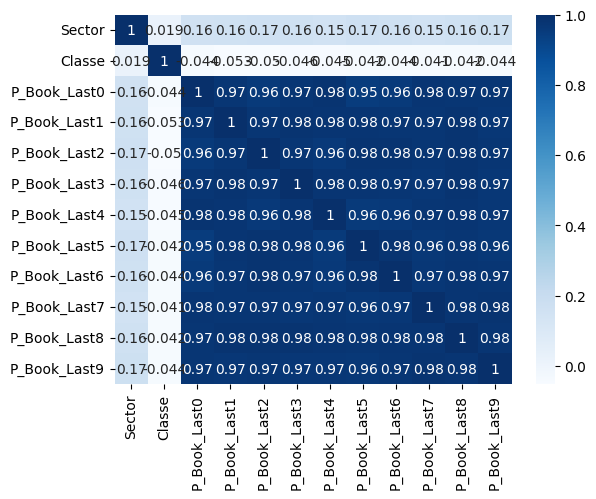

In [38]:
#Correlations 
ev_ebitda_df_V2.corr()['P_Book_Last9']
sns.heatmap ( ev_ebitda_df_V2.corr(), annot = True,  cmap = 'Blues' )

In [13]:
#Normalization des données 
ev_ebitda_df_V2_ = ev_ebitda_df_V2.drop ( ['P_Book_Last9'] , axis = 1).copy()
ev_ebitda_df_V2_ = StandardScaler().fit_transform (ev_ebitda_df_V2_)
ev_ebitda_df_V2_ = pd.DataFrame ( ev_ebitda_df_V2_, columns = ev_ebitda_df_V2.drop ( ['P_Book_Last9'] , axis = 1).columns, index = ev_ebitda_df_V2.drop ( ['EV/EBITDA9'] , axis = 1).index )
ev_ebitda_df_V2_ ['EV/EBITDA9'] = ev_ebitda_df_V2['EV/EBITDA9']
ev_ebitda_df_V2_

KeyError: "['EV/EBITDA9'] not found in axis"

#####  X et y train test split

In [89]:
#Mélange des données 
data_shuffled = ev_ebitda_df_V2.sample ( frac = 1, random_state = 40 )
data_shuffled

,Sector,Classe,P_Book_Last0,P_Book_Last1,P_Book_Last2,P_Book_Last3,P_Book_Last4,P_Book_Last5,P_Book_Last6,P_Book_Last7,P_Book_Last8,P_Book_Last9
805,70,0.0,2.49,2.79,2.33,2.74,2.73,2.89,2.07,2.98,2.90,2.95
27,25,4.0,0.47,0.59,0.75,0.19,0.54,0.56,0.27,0.96,0.56,0.48
861,104,3.0,3.06,3.92,3.10,3.67,3.21,3.61,3.26,3.05,3.55,3.39
851,83,3.0,1.56,1.14,1.82,1.58,1.04,1.89,1.38,1.01,1.09,1.11
43,44,4.0,2.17,2.86,2.62,2.92,2.55,2.85,2.22,2.53,2.20,2.85
...,...,...,...,...,...,...,...,...,...,...,...,...
441,37,2.0,2.28,2.04,2.45,2.37,2.77,2.82,2.37,2.81,2.35,2.46
166,61,4.0,0.21,0.23,0.36,0.37,0.93,0.82,0.65,0.83,0.77,0.61
8,71,4.0,1.00,1.74,1.52,1.53,1.71,1.01,1.98,1.18,1.05,1.26
220,90,4.0,1.39,1.06,1.49,1.32,1.08,1.64,1.62,1.45,1.24,1.48


In [90]:
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

X = data_shuffled.drop ( ['P_Book_Last9'], axis = 1 )
y = data_shuffled ['P_Book_Last9']

#YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY
y

805    2.95
27     0.48
861    3.39
851    1.11
43     2.85
       ... 
441    2.46
166    0.61
8      1.26
220    1.48
327    1.06
Name: P_Book_Last9, Length: 884, dtype: float64

In [95]:
intervalle = pd.cut ( y, bins = [ 0, 5, 15, 20 ] )
intervalle

805    (0, 5]
27     (0, 5]
861    (0, 5]
851    (0, 5]
43     (0, 5]
        ...  
441    (0, 5]
166    (0, 5]
8      (0, 5]
220    (0, 5]
327    (0, 5]
Name: P_Book_Last9, Length: 884, dtype: category
Categories (3, interval[int64, right]): [(0, 5] < (5, 15] < (15, 20]]

In [96]:
#X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split ( X, y, stratify = intervalle,  train_size = 0.92 )
#X_train,  X_validation, y_train, y_validation = train_test_split ( X_train, y_train, stratify = y_train,  train_size = 0.96 )
print ( 'X_train size :', X_train.shape )
print ( 'y_train size :', y_train.shape )
#print ( 'X_validation size :', X_validation.shape )
#print ( 'y_validation size :', y_validation.shape )
print ( 'X_test size :', X_test.shape )
print ( 'y_test size :', y_test.shape )

X_train size : (813, 11)
y_train size : (813,)
X_test size : (71, 11)
y_test size : (71,)


In [98]:
y_test.sort_values()

299     0.23
116     0.24
265     0.28
155     0.30
321     0.31
       ...  
176     2.79
607     2.92
97      3.80
462     5.13
70     11.49
Name: P_Book_Last9, Length: 71, dtype: float64

### Prediction Models Prédire EV/EBITDA

#### Linear Regression

In [99]:
#Modele de regression linear
model_regression_linear = LinearRegression()
model_regression_linear.fit (X_train, y_train) 
model_regression_linear

LinearRegression()

In [100]:
#R2score data d'entrainnement
y_train_predicted = model_regression_linear.predict ( X_train )

print ('MSE du modèl LinearRegression = ', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du modèl LinearRegression =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'R2 score du modèl LinearRegression = ', r2_score ( y_train, y_train_predicted ) )

MSE du modèl LinearRegression =  0.09651977427264097
MAE du modèl LinearRegression = 0.24743170111872542
R2 score du modèl LinearRegression =  0.9744634459094904


In [101]:
#R2score data de test
y_test_predicted = model_regression_linear.predict ( X_test )

print ('MSE du modèl LinearRegression = ', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du modèl LinearRegression =', np.mean ( np.abs(y_test - y_test_predicted) ) )
print ( 'R2 score du modèl LinearRegression = ', r2_score ( y_test, y_test_predicted ) )

MSE du modèl LinearRegression =  0.08364942737503207
MAE du modèl LinearRegression = 0.23851623264024077
R2 score du modèl LinearRegression =  0.9616983991557799


Text(0, 0.5, 'P/Book')

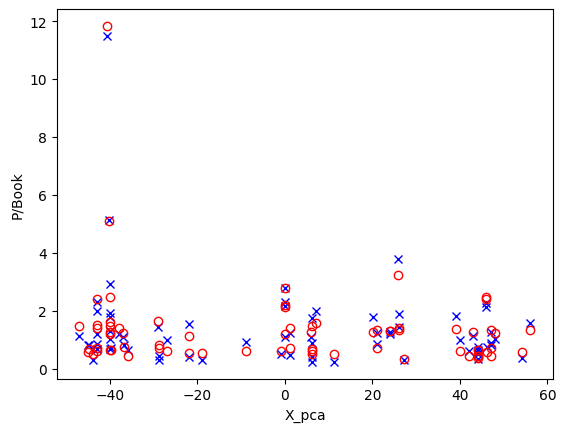

In [102]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_test)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_test.index )

#Predictions
#y_train_predicted = model_linear_regression.predict (X_train)

#Visualisation
plt.plot ( X_pca, y_test, 'bx' )
plt.plot ( X_pca, y_test_predicted, 'ro', fillstyle = 'none' )
plt.xlabel ( 'X_pca' )
plt.ylabel ("P/Book")

#### Gradient Boosting

In [124]:
#Search grid
prams_grid = { 'n_estimators' : [ 61, 62, 63, 64, 65, 66, 67, 68], 'max_depth' : [2, 3, 4, 5] }
search_grid = GridSearchCV ( estimator = GradientBoostingRegressor (), param_grid = prams_grid, cv = 5 )
search_grid.fit (X_train, y_train)
search_grid.best_params_

{'max_depth': 2, 'n_estimators': 61}

In [148]:
#Initialisation et entrainnement du model
model_gradient_boosting = GradientBoostingRegressor (n_estimators = 65, max_depth= 3 )
model_gradient_boosting.fit( X_train, y_train )
model_gradient_boosting

GradientBoostingRegressor(n_estimators=65)

In [149]:
#R2score data d'entrainnement
y_train_predicted = model_gradient_boosting.predict ( X_train )

print ( 'MSE du model  = ', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du model  =', np.mean ( np.abs(y_train - y_train_predicted) ))
print ( 'Coefecient de correlation de Pearson =', np.corrcoef ( y_train, y_train_predicted  )[0,1])
print ( 'R2 score du model  = ', r2_score ( y_train, y_train_predicted ))

MSE du model  =  0.04889330694781183
MAE du model  = 0.18352072604730268
Coefecient de correlation de Pearson = 0.9935319653528437
R2 score du model  =  0.9870641369921791


In [150]:
#R2score data de test
y_test_predicted = model_gradient_boosting.predict ( X_test )

print ('MSE du model  = ', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du model  =', np.mean ( np.abs(y_test - y_test_predicted) ) )
print ( 'Coeffecient de correlation de Pearson =', np.corrcoef ( y_test, y_test_predicted  )[0,1])
print ( 'R2 score du model  = ', r2_score ( y_test, y_test_predicted ) )

MSE du model  =  0.08130528066882116
MAE du model  = 0.24139247725000051
Coeffecient de correlation de Pearson = 0.98141106771361
R2 score du model  =  0.9627717426833937


Text(0, 0.5, 'EV/EBITDA')

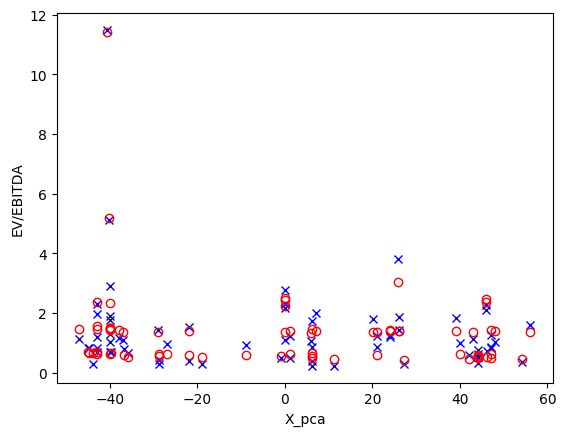

In [151]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_test)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_test.index )

#Predictions
#y_train_predicted = model_linear_regression.predict (X_train)

#Visualisation
plt.plot ( X_pca, y_test, 'bx' )
plt.plot ( X_pca, y_test_predicted, 'ro', fillstyle = 'none' )
plt.xlabel ( 'X_pca' )
plt.ylabel ("EV/EBITDA")

In [153]:
#Analyse des erreurs
erreur = y_test - y_test_predicted
#erreur = erreur
erreur
px.bar ( y = erreur.abs() )

In [158]:
with open ( 'Models_V2/Model_Gradient_Boosting_P_Book_value.pkl', 'wb' ) as f:
    pickle.dump ( model_gradient_boosting, f )

#### Model de la moyen 

In [155]:
#Performance du model de la moyenne 
y_moyenne = np.mean (X.drop  (['Sector', 'Classe'], axis = 1), axis = 1)

print ('MSE du model de la moyenn = ', np.mean ( (y - y_moyenne) ** 2 ))
print ( 'MAE du model de la moyenn =', np.mean ( np.abs(y - y_moyenne) ) )
print ( 'Coefecient de correlation de Pearson =', np.corrcoef ( y, y_moyenne  )[0,1] )
print ( 'R2 score du model de la moyenn = ', r2_score ( y, y_moyenne ) )

MSE du model de la moyenn =  0.1332735084632144
MAE du model de la moyenn = 0.25352815485168434
Coefecient de correlation de Pearson = 0.9841738693554917
R2 score du model de la moyenn =  0.9635073843088358


In [157]:
y_predicted = model_gradient_boosting.predict (X)

print ('MSE du model de la moyenn = ', np.mean ( (y - y_predicted) ** 2 ))
print ( 'MAE du model de la moyenn =', np.mean ( np.abs(y - y_predicted) ) )
print ( 'Coefecient de correlation de Pearson =', np.corrcoef ( y, y_predicted  )[0,1])
print ( 'R2 score du model de la moyenn = ', r2_score ( y, y_predicted ) )

MSE du model de la moyenn =  0.0514965310815128
MAE du model de la moyenn = 0.18816879656245147
Coefecient de correlation de Pearson = 0.9929462990850894
R2 score du model de la moyenn =  0.9858993498418747


#### SVM

In [68]:
model_svm = svm.SVC (  ).fit ( X_train, y_train )
model_svm

SVC()

In [69]:
#Performance du model
y_train_predicted = model_svm.predict ( X_train )
print ('Accuracy score sur les données train =', accuracy_score( y_train, y_train_predicted )) 

#Performance du model
y_test_predicted = model_svm.predict ( X_test )
print ('Accuracy score sur les données test =', accuracy_score( y_test, y_test_predicted ))

print ('F1 score = ', f1_score( y_test, y_test_predicted, average = 'macro' ) ) 

Accuracy score sur les données train = 0.5201684397163121
Accuracy score sur les données test = 0.5212765957446809
F1 score =  0.2391937833899951


#### Logistique Regression 

In [70]:
model_LR = LogisticRegression ().fit (X_train, y_train)
model_LR

LogisticRegression()

In [71]:
#Performance du model
y_train_predicted = model_LR.predict ( X_train )
print ('Accuracy score sur les données train =', accuracy_score( y_train, y_train_predicted )) 

#Performance du model
y_test_predicted = model_LR.predict ( X_test )
print ('Accuracy score sur les données test =', accuracy_score( y_test, y_test_predicted ))

print ('F1 score = ', f1_score( y_test, y_test_predicted, average = 'macro' ) )

Accuracy score sur les données train = 0.5226063829787234
Accuracy score sur les données test = 0.5212765957446809
F1 score =  0.24961593061470544


#### Réseaux de neuronnes

In [204]:
#Initialisation du modèle 
num_unit1 = 50
num_unit2 = 50
num_unit3 = 50
num_unit4 = 50
num_unit5 = 50
num_unit6 = 50
num_unit7 = 50

taux_dropout = 0.1

model_DNN_ev = keras.models.Sequential ( name  = 'Model_DNN' )

#Input layer
model_DNN_ev.add ( layers.Input ( (X_train.shape [1],) , name = 'Input_layer'  ) )
#Hidden Layer 1
model_DNN_ev.add ( layers.Dense ( num_unit1, activation = 'relu', kernel_regularizer = regularizers.L2 (0.01), name = 'Hidden_layer1' ) )
model_DNN_ev.add ( layers.Dropout ( taux_dropout ))
#Hidden Layer 2
model_DNN_ev.add ( layers.Dense ( num_unit2, activation = 'relu', kernel_regularizer = regularizers.L2 (0.01), name = 'Hidden_layer2' ) )
#model_DNN_ev.add ( layers.Dropout ( taux_dropout ))
#Hidden Layer 3
model_DNN_ev.add ( layers.Dense ( num_unit3, activation = 'relu', kernel_regularizer = regularizers.L2 (0.01), name = 'Hidden_layer3' ) )
#model_DNN_ev.add ( layers.Dropout ( taux_dropout ))
#model_DNN_ev.add ( layers.Dropout ( taux_dropout ))
#Hidden Layer 4
#model_DNN_ev.add ( layers.Dense ( num_unit4, activation = 'relu', kernel_regularizer = regularizers.L2 (0.001), name = 'Hidden_layer4' ) )
#model_DNN_ev.add ( layers.Dropout ( taux_dropout ))
#Hidden Layer 5
#model_DNN_ev.add ( layers.Dense ( num_unit5, activation = 'relu', name = 'Hidden_layer5' ) )
#Hidden Layer 6
#model_DNN_ev.add ( layers.Dense ( num_unit6, activation = 'relu', name = 'Hidden_layer6' ) )
#Hidden Layer 7
#model_DNN_ev.add ( layers.Dense ( num_unit7, activation = 'relu', name = 'Hidden_layer7' ) )
#Output layer
model_DNN_ev.add ( layers.Dense ( 1, name = 'Output_layer' ) )

In [205]:
#Propréités du model
#'sparse_categorical_crossentropy'
model_DNN_ev.compile ( optimizer = optimizers.Adam ( 0.00001 ),
                    loss = 'MSE',
                    metrics = ['MAE'] )

In [206]:
#Récaputiatif du model
model_DNN_ev.summary()

Model: "Model_DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_layer1 (Dense)       (None, 50)                550       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 Hidden_layer2 (Dense)       (None, 50)                2550      
                                                                 
 Hidden_layer3 (Dense)       (None, 50)                2550      
                                                                 
 Output_layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 5,701
Trainable params: 5,701
Non-trainable params: 0
_________________________________________________________________


In [207]:
#Entrainnement du model
#callbacks = keras.callbacks.LearningRateScheduler ( schedule ),
hist = model_DNN_ev.fit ( X_train, y_train,
                       epochs = 1600,
                       batch_size = 36,
                       validation_data = ( X_test, y_test ) )

Epoch 1/1600
16/16 [==============================] - 1s 25ms/step - loss: 331.4955 - MAE: 13.6689 - val_loss: 318.8448 - val_MAE: 12.7718
Epoch 2/1600
16/16 [==============================] - 0s 9ms/step - loss: 323.8184 - MAE: 13.4669 - val_loss: 307.7854 - val_MAE: 12.4920
Epoch 3/1600
16/16 [==============================] - 0s 10ms/step - loss: 308.0269 - MAE: 13.1476 - val_loss: 296.8883 - val_MAE: 12.2246
Epoch 4/1600
16/16 [==============================] - 0s 8ms/step - loss: 293.2676 - MAE: 12.9766 - val_loss: 287.0663 - val_MAE: 11.9815
Epoch 5/1600
16/16 [==============================] - 0s 6ms/step - loss: 297.4178 - MAE: 12.9219 - val_loss: 277.4964 - val_MAE: 11.7364
Epoch 6/1600
16/16 [==============================] - 0s 6ms/step - loss: 276.1998 - MAE: 12.4074 - val_loss: 268.2421 - val_MAE: 11.4950
Epoch 7/1600
16/16 [==============================] - 0s 6ms/step - loss: 264.4236 - MAE: 12.0781 - val_loss: 259.1541 - val_MAE: 11.2762
Epoch 8/1600
16/16 [============

In [208]:
#La df crossentropy
epoch = range(1, len(hist.history['loss']) + 1)
crossentropy = pd.DataFrame ( { 'epoch' : epoch, 'crossentropy_train' : hist.history['loss'], 'crossentropy_validation' : hist.history['val_loss'] } )

#Evolution de la fonction objective -crossentropy- en fonction du nombre d'epochs
fig2 = px.line ( crossentropy, x = 'epoch', y = [ 'crossentropy_train', 'crossentropy_validation' ], width = 1300, height = 600 )
fig2.update_layout ( title = '''Evolution de la fonction objective -crossentropy- en fonction du nombre d'epochs ''' )
fig2.show()

In [209]:
#R2score data de train
y_train_predicted = model_DNN_ev.predict ( X_train )
y_train_predicted = y_train_predicted.reshape (y_train.shape)

print ('MSE du model  = ', np.mean ( (y_train - y_train_predicted) ** 2 ))
print ( 'MAE du model  =', np.mean ( np.abs(y_train - y_train_predicted) ) )
print ( 'Coefecient de correlation de Pearson = ', np.corrcoef ( y_train, y_train_predicted )[0,1] )
print ( 'R2 score du model  = ', r2_score ( y_train, y_train_predicted ) )

17/17 [==============================] - 0s 2ms/step
MSE du model  =  9.862928794820373
MAE du model  = 2.305800061427866
Coefecient de correlation de Pearson =  0.9710713115356026
R2 score du model  =  0.922669879447349


In [210]:
#R2score data de test
y_test_predicted = model_DNN_ev.predict ( X_test )
y_test_predicted = y_test_predicted.reshape (y_test.shape)

print ('MSE du model  = ', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du model  =', np.mean ( np.abs(y_test - y_test_predicted) ))
print ( 'Coefecient de correlation de Pearson = ', np.corrcoef ( y_test, y_test_predicted )[0,1] )
print ( 'R2 score du model  = ', r2_score ( y_test, y_test_predicted ))

2/2 [==============================] - 0s 4ms/step
MSE du model  =  11.365730620945513
MAE du model  = 2.4044507459799447
Coefecient de correlation de Pearson =  0.9718729009211767
R2 score du model  =  0.9192525175915685


In [178]:
y_df = pd.DataFrame ( { 'y_test' : y_test, 'y_test_predicted': y_test_predicted } )
px.line ( y_df, x = range ( len (y_test) ), y = ["y_test", 'y_test_predicted'], width = 800 )

Text(0, 0.5, 'EV/EBITDA')

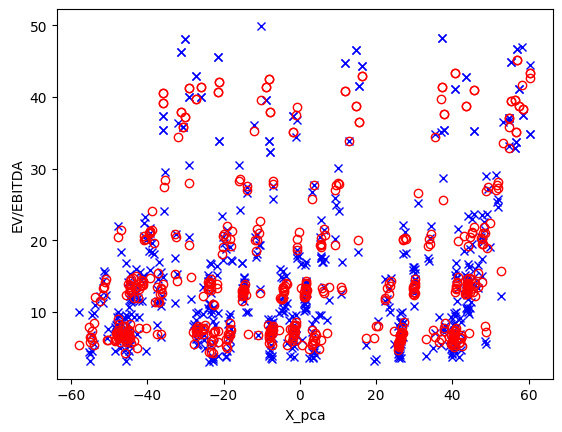

In [179]:
#Visulaization utlisons PCA
X_pca = PCA (n_components = 1).fit_transform (X_train)
X_pca = pd.DataFrame ( X_pca, columns = ['X1'], index = X_train.index )

#Predictions
#y_train_predicted = model_linear_regression.predict (X_train)

#Visualisation
plt.plot ( X_pca, y_train, 'bx' )
plt.plot ( X_pca, y_train_predicted, 'ro', fillstyle = 'none' )
plt.xlabel ( 'X_pca' )
plt.ylabel ("EV/EBITDA")

#### Random Forest

In [491]:
model_random_forest = RandomForestClassifier ( n_estimators = 50, max_depth = 5  ).fit ( X_train, y_train )
model_random_forest

RandomForestClassifier(max_depth=5, n_estimators=50)

In [490]:
#Performance du model
y_train_predicted = model_random_forest.predict ( X_train )
print ('Accuracy score sur les données train =', accuracy_score( y_train, y_train_predicted )) 

#Performance du model
y_test_predicted = model_random_forest.predict ( X_test )
print ('Accuracy score sur les données test =', accuracy_score( y_test, y_test_predicted ))

print ('F1 score = ', f1_score( y_test, y_test_predicted, average = 'macro' ) ) 

Accuracy score sur les données train = 0.3647729765299408
Accuracy score sur les données test = 0.2907801418439716
F1 score =  0.12250678780284044


#### Test 

In [33]:
with open ( 'Models_V2/Model_GradBoosting_EV_EBITDA.pkl', 'rb' ) as f:
    model_ev_ebitda = pickle.load(  f )

In [52]:
#R2score data de test
y_test_predicted = model_ev_ebitda.predict ( X_test )

print ('MSE du model  = ', np.mean ( (y_test - y_test_predicted) ** 2 ))
print ( 'MAE du model  =', np.mean ( np.abs(y_test - y_test_predicted) ) )
print ( 'Coeffecient de correlation de Pearson =', np.corrcoef ( y_test, y_test_predicted  )[0,1])
print ( 'R2 score du model  = ', r2_score ( y_test, y_test_predicted ) )

MSE du model  =  4.441726626511698
MAE du model  = 1.7413004909326086
Coeffecient de correlation de Pearson = 0.9692940249783234
R2 score du model  =  0.9313202349226106
